# **Connect to the drive to extract the datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Set the path**

In [ ]:
path = '/content/drive/MyDrive/mltask2/'

#Install the Dask to read the file in large number of data

In [ ]:
# Step 1: Install Dask
!pip install dask --quiet

# Import The Libraries

In [ ]:
# Step 2: Import Libraries
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **Read the files **

In [ ]:
# Load small/medium files directly with dtype control
assessment = dd.read_csv(path + 'assessments.csv', dtype={
    'code_module': 'object',
    'code_presentation': 'object',
    'id_assessment': 'int64',
    'assessment_type': 'object',
    'date': 'float64',
    'weight': 'float64'
})

courses = dd.read_csv(path + 'courses.csv', dtype={
    'code_module': 'object',
    'code_presentation': 'object',
    'module_presentation_length': 'int64'
})

student_assessment = dd.read_csv(path + 'studentAssessment.csv', dtype={
    'id_assessment': 'int64',
    'id_student': 'int64',
    'date_submitted': 'float64',
    'is_banked': 'int64',
    'score': 'float64'
})

student_info = dd.read_csv(path + 'studentInfo.csv', dtype={
    'code_module': 'object',
    'code_presentation': 'object',
    'id_student': 'int64',
    'gender': 'object',
    'region': 'object',
    'highest_education': 'object',
    'imd_band': 'object',
    'age_band': 'object',
    'num_of_prev_attempts': 'int64',
    'studied_credits': 'int64',
    'disability': 'object',
    'final_result': 'object'
})

student_registration = dd.read_csv(path + 'studentRegistration.csv', dtype={
    'code_module': 'object',
    'code_presentation': 'object',
    'id_student': 'int64',
    'date_registration': 'float64',
    'date_unregistration': 'float64'
})



# **StudenVle dataset is large so divide into cunks**

In [ ]:
# 🔁 Load large file in chunks (Dask handles this efficiently)
student_vle = dd.read_csv(path + 'studentVle.csv', blocksize='100MB', dtype={
    'code_module': 'object',
    'code_presentation': 'object',
    'id_student': 'int64',
    'id_site': 'int64',
    'date': 'float64',
    'sum_click': 'float64'
})

vle = dd.read_csv(path + 'vle.csv', dtype={
    'id_site': 'int64',
    'code_module': 'object',
    'code_presentation': 'object',
    'activity_type': 'object'
})

The total number of clicks and the number of active days on the VLE (Virtual Learning Environment). It then merges and saves the aggregated results to a CSV file to avoid repeating the computations.

In [ ]:
# Total clicks per student
total_clicks = student_vle.groupby('id_student')['sum_click'].sum().reset_index()
total_clicks = total_clicks.rename(columns={'sum_click': 'total_clicks'})

# Number of active days
active_days = student_vle.groupby('id_student')['date'].nunique().reset_index()
active_days = active_days.rename(columns={'date': 'active_days'})

# Merge both aggregations
vle_agg = total_clicks.merge(active_days, on='id_student')

# Now compute final aggregated student VLE info
vle_agg_df = vle_agg.compute()

# Optional: Save it to avoid recomputation
vle_agg_df.to_csv('/content/drive/MyDrive/mltask2/vle_aggregated.csv', index=False)


# **Merge the Datasets**

Multiple datasets to build a complete student profile, including assessment scores, demographics, and course registration. It then combines this profile with VLE activity data to prepare for further analysis.

In [ ]:
# Load other datasets as before

# Merge step by step
merged1 = student_assessment.merge(assessment, on='id_assessment', how='left')
merged2 = merged1.merge(student_info, on=['id_student', 'code_module', 'code_presentation'], how='left')
merged3 = merged2.merge(student_registration, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Now merge with preprocessed VLE aggregated data (small)
merged_final = merged3.compute().merge(vle_agg_df, on='id_student', how='left')


calculates two features for each student: their average assessment score and the total number of unique assessments they've attempted. These metrics help in evaluating student performance and engagement.

In [ ]:
# Average score
avg_score = merged_final.groupby('id_student')['score'].mean().reset_index(name='avg_score')

# Number of assessments
num_assess = merged_final.groupby('id_student')['id_assessment'].nunique().reset_index(name='num_assessments')


 New column days_studied by subtracting the student's registration date from their unregistration date. It shows how long each student stayed active in the course.

In [ ]:
# Registration duration (last activity - registration date)
merged_final['days_studied'] = merged_final['date_unregistration'] - merged_final['date_registration']


New dataset features_df by combining important features for each student: their average score, number of assessments taken, total clicks, number of active days, study duration, and final course result. It merges these features step-by-step using the student ID.

In [ ]:
# Start with avg_score
features_df = avg_score.merge(num_assess, on='id_student', how='left')

# Add click and activity features
features_df = features_df.merge(merged_final[['id_student', 'total_clicks', 'active_days']].drop_duplicates(), on='id_student', how='left')

# Add duration and final result
features_df = features_df.merge(merged_final[['id_student', 'days_studied', 'final_result']].drop_duplicates(), on='id_student', how='left')


suspected cheaters by flagging students with high scores (≥85) but low engagement, such as fewer than 50 total clicks, fewer than 5 active days, and less than 3 assessments completed. The is_cheater column is set to True for these students and False otherwise.


In [ ]:
# Define suspected cheaters
# These are students who got high scores with low engagement
features_df['is_cheater'] = (
    (features_df['avg_score'] >= 85) &
    (features_df['total_clicks'] < 50) &
    (features_df['active_days'] < 5) &
    (features_df['num_assessments'] < 3)
)


In [ ]:
# View suspected cheaters
cheaters = features_df[features_df['is_cheater'] == True]
print("Number of suspected cheaters:", cheaters.shape[0])
cheaters.head()


Number of suspected cheaters: 38


,id_student,avg_score,num_assessments,total_clicks,active_days,days_studied,final_result,is_cheater
15,25997,86.5,2,13.0,1.0,222.0,Withdrawn,True
3490,380515,100.0,1,21.0,2.0,98.0,Withdrawn,True
3586,384266,100.0,1,13.0,3.0,48.0,Withdrawn,True
3628,386374,90.0,1,18.0,4.0,NaN,Fail,True
4402,425314,100.0,1,12.0,1.0,95.0,Withdrawn,True


# **Detecting Cheaters Using Isolation Forest (Anomaly Detection)**
prepares numeric student features, fills missing values with 0, and scales the data using StandardScaler. An Isolation Forest model is then trained to detect anomalies, labeling students with unusual behavior (e.g., high score but low activity) as potential cheaters. Those flagged as anomalies (-1) are marked in a new column is_cheater_ml, and the number of such students is displayed.

In [ ]:
!pip install -q scikit-learn

import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


In [ ]:
# Drop non-numeric / identifier columns
X = features_df[['avg_score', 'num_assessments', 'total_clicks', 'active_days', 'days_studied']].copy()

# Fill missing values
X.fillna(0, inplace=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Train Isolation Forest
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
features_df['anomaly_score'] = iso_model.fit_predict(X_scaled)

# Add label: -1 = anomaly (potential cheater), 1 = normal
features_df['is_cheater_ml'] = features_df['anomaly_score'] == -1


In [ ]:
# Show suspected cheaters
ml_cheaters = features_df[features_df['is_cheater_ml']]
print("Total suspected cheaters (ML):", ml_cheaters.shape[0])
ml_cheaters.head()


Total suspected cheaters (ML): 1253


,id_student,avg_score,num_assessments,total_clicks,active_days,days_studied,final_result,is_cheater,anomaly_score,is_cheater_ml
18,26211,89.250000,12,15205.0,248.0,NaN,Pass,False,-1,True
45,29639,83.769231,13,10503.0,271.0,NaN,Pass,False,-1,True
95,35355,75.222222,9,3358.0,150.0,224.0,Withdrawn,False,-1,True
132,42638,72.384615,13,11845.0,252.0,NaN,Pass,False,-1,True
134,42746,94.571429,21,10673.0,219.0,NaN,Distinction,False,-1,True


In [ ]:
ml_cheaters.to_csv('/content/drive/MyDrive/mltask2/ml_suspected_cheaters.csv', index=False)


# **Comparing Rule-Based and ML-Based Cheater Detection**
compares students flagged as cheaters by both the rule-based method (is_cheater) and the machine learning model (is_cheater_ml). A new column cheater_status categorizes each student as "Both", "Rule-Based Only", "ML-Based Only", or "Neither". Finally, it summarizes the count of students in each category.

In [ ]:
# Ensure both columns exist
comparison_df = features_df[['id_student', 'avg_score', 'total_clicks', 'days_studied', 'is_cheater', 'is_cheater_ml']]


In [ ]:
# Create a summary column
comparison_df['cheater_status'] = comparison_df.apply(
    lambda row: 'Both' if row['is_cheater'] and row['is_cheater_ml']
    else 'Rule-Based Only' if row['is_cheater']
    else 'ML-Based Only' if row['is_cheater_ml']
    else 'Neither', axis=1)

# Count of each category
cheater_summary = comparison_df['cheater_status'].value_counts().reset_index()
cheater_summary.columns = ['Cheater Type', 'Number of Students']
cheater_summary


<ipython-input-20-ca9c1d705236>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df['cheater_status'] = comparison_df.apply(


,Cheater Type,Number of Students
0,Neither,23757
1,ML-Based Only,1252
2,Rule-Based Only,37
3,Both,1


**Rule-Based vs ML-Based Cheaters**

Most students were not flagged by either method, while a small number were caught by ML only, even fewer by Rule-Based only, and almost none by both methods.

<ipython-input-21-5c04d999acb0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cheater_summary, x='Cheater Type', y='Number of Students', palette='Set2')


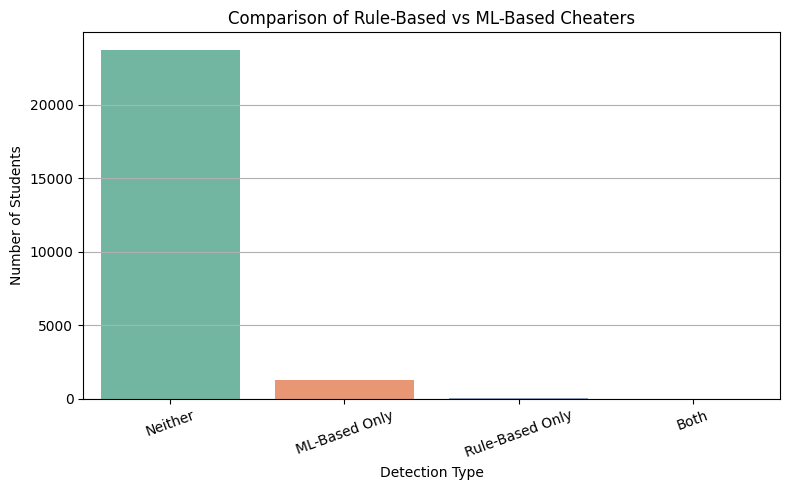

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=cheater_summary, x='Cheater Type', y='Number of Students', palette='Set2')
plt.title("Comparison of Rule-Based vs ML-Based Cheaters")
plt.ylabel("Number of Students")
plt.xlabel("Detection Type")
plt.xticks(rotation=20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Overlap in Cheater Detection: Rule-Based vs. ML**

Most students were not flagged by either method, while a small number were caught by ML only, even fewer by Rule-Based only, and almost none by both methods.

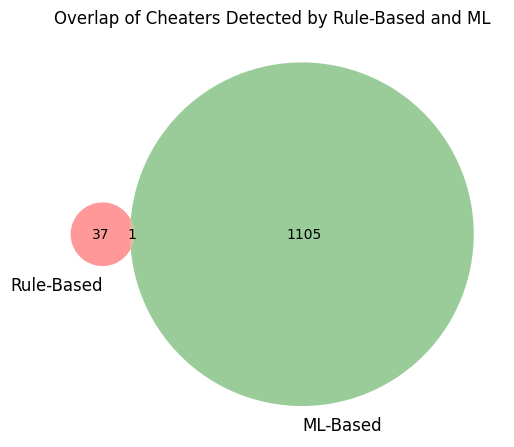

In [ ]:
!pip install matplotlib-venn

from matplotlib_venn import venn2

rule_cheaters = set(comparison_df[comparison_df['is_cheater']]['id_student'])
ml_cheaters = set(comparison_df[comparison_df['is_cheater_ml']]['id_student'])

plt.figure(figsize=(6, 6))
venn2([rule_cheaters, ml_cheaters], set_labels=('Rule-Based', 'ML-Based'))
plt.title("Overlap of Cheaters Detected by Rule-Based and ML")
plt.show()


In [ ]:
cheaters.to_csv("/content/rule_based_cheaters.csv", index=False)
print("✅ Saved rule-based cheaters to 'rule_based_cheaters.csv'")


✅ Saved rule-based cheaters to 'rule_based_cheaters.csv'


In [ ]:
features_df.to_csv("/content/student_features.csv", index=False)
print("✅ Saved student features to 'student_features.csv'")


✅ Saved student features to 'student_features.csv'
